In [88]:
import numpy as np
from numpy import unique
from numpy import where
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame
from sklearn.cluster import KMeans
from sklearn import datasets
import sklearn.cluster as skl_cluster
import sklearn.datasets.samples_generator as skl_smpl
from matplotlib import pyplot as plt

In [89]:
np.random.seed(5)

iris = datasets.load_iris()
x_iris = iris.data
y_iris = iris.target

In [90]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [157]:
class KerKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, centroids=3, loop=50, cap=1e-3, random_state=None,
                 kernel="laplacian", gamma=0.001, degree=2, df=1,
                 vals=None, backG=0):
        self.centroids = centroids
        self.loop = loop
        self.cap = cap
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.df = df
        self.vals = vals
        self.backG = backG


    def KernelComputation(self, X, Y=None):
        if callable(self.kernel):
            kernel_values = self.vals or {}
        else:
            kernel_values = {"gamma": self.gamma,
                      "degree": self.degree,
                      "df": self.df}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **kernel_values)

    def fit(self, X, y=None, wt=None):
        total = X.shape[0]
        
        K = self.KernelComputation(X)
        WithinS = wt if wt else np.ones(total)
        self.wt = WithinS
        
        self_rand = check_random_state(self.random_state)
        self.labels_ = self_rand.randint(self.centroids, size=total)
        dist = np.zeros((total, self.centroids))
        self.Distance_matrix_within = np.zeros(self.centroids)
        for it in range(self.loop):
            dist.fill(0)
            self.EqdDistance(K, dist, self.Distance_matrix_within,check=True)
            predicts1 = self.labels_
            self.labels_ = dist.argmin(axis=1)           
            pq = np.sum((self.labels_ - predicts1) == 0)
            if 1 - float(pq) / total < self.cap:
                if self.backG:
                    print ("Done", it + 1)
                break

        self.X_fit_ = X
        return self

    def EqdDistance(self, K, dist, within_distances, check):
        WithinS = self.wt
        for j in range(self.centroids):
            fk = self.labels_== j
            if np.sum(fk) == 0:
                raise ValueError("Data not found in cluster")
            A = WithinS[fk].sum()
            Asquare = A * A
            if check:
                Ksquare = K[fk][:, fk]  
                dist_j = np.sum(np.outer(WithinS[fk], WithinS[fk]) * Ksquare / Asquare)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(WithinS[fk] * K[:, fk], axis=1) / A
    @property
    def KernelPair(self):
        return self.kernel == "precomputed"
    def predict(self, X):
        A = self.KernelComputation(X, self.X_fit_)
        total = X.shape[0]
        XX = np.zeros((total, self.centroids))
        self.EqdDistance(A, XX, self.Distance_matrix_within,
                           check=False)
        return XX.argmin(axis=1)

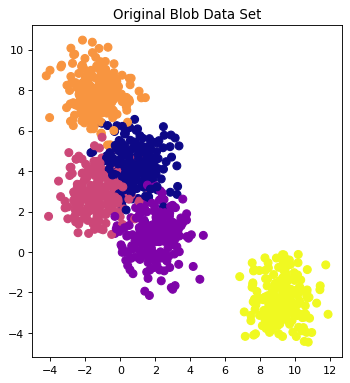

In [158]:
if __name__ == '__main__':
    from sklearn.datasets import make_blobs
    X_blobs, y_blobs = make_blobs(n_samples=1000, centers=5, random_state=0)
    
    #plotting original Data 
    plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, s=50, cmap='plasma')
    plt.rcParams.update({'figure.figsize':(6,5.5), 'figure.dpi':30})
    plt.title("Original Blob Data Set")

Text(0.5, 1.0, 'K means clustering on Blob Data')

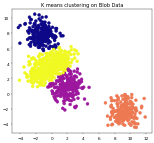

In [159]:
#Standard K means 
Kmean = skl_cluster.KMeans(n_clusters=4)
Kmean.fit(X_blobs)
clusters_blobs = Kmean.predict(X_blobs)

#plotting After K means Data 
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=clusters_blobs, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':100})
plt.title("K means clustering on Blob Data")

In [160]:
#Kernalized K means
km = KerKMeans(centroids=5, loop=100, random_state=0, backG=1)
print (km.fit_predict(X_blobs)[:10])
print (km.predict(X_blobs[:10]))
yhat_blobs=km.predict(X_blobs)

Done 15
[2 3 0 0 4 4 1 4 4 0]
[2 3 0 0 4 4 1 4 4 0]


Text(0.5, 1.0, 'Kernel K-means clustering on Blob Data')

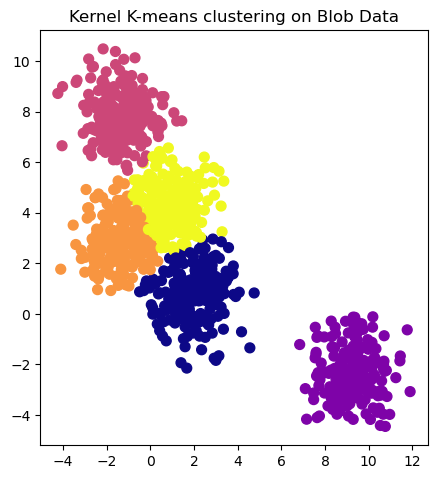

In [161]:
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=yhat_blobs, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':70})
plt.title("Kernel K-means clustering on Blob Data")

Text(0.5, 1.0, 'Iris Data')

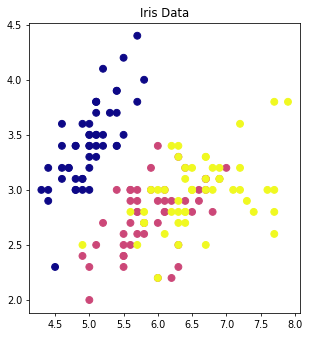

In [162]:
plt.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':70})
plt.title("Iris Data")

In [163]:
#Standard K means on Iris Data Set
Kmean = skl_cluster.KMeans(n_clusters=3)
Kmean.fit(x_iris)
yhat = Kmean.predict(x_iris)

Text(0.5, 1.0, 'K-means clustering on Iris Data')

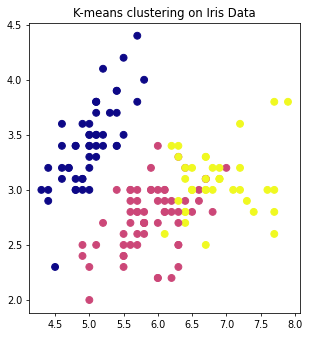

In [164]:
plt.scatter(x_iris[:, 0], x_iris[:, 1], c=yhat, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':70})
plt.title("K-means clustering on Iris Data")

In [165]:
#Kernel K means on Iris Data Set
km = KerKMeans(centroids=2, loop=1000, random_state=0, backG=1)
print (km.fit_predict(x_iris)[:150])
print (km.predict(x_iris[:150]))

yhat_iris = km.predict(x_iris)
    

Done 6
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


Text(0.5, 1.0, 'Kernel K-means clustering on Iris Data')

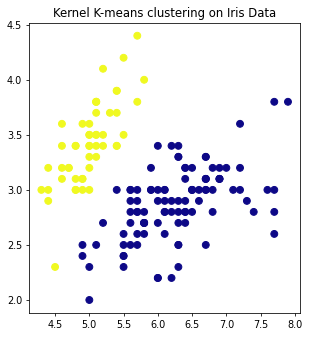

In [166]:
plt.scatter(x_iris[:, 0], x_iris[:, 1], c=yhat_iris, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':80})
plt.title("Kernel K-means clustering on Iris Data")